# CNN Pipeline
The notebook training the Siamese Neural Network, and testing/validating it.

### 1] imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
FAKE_DIR = '/content/gdrive/MyDrive/ds/fake/'
MODEL_PATH = '/content/gdrive/MyDrive/checkpoints/'
SCRIPT_PATH = '/content/gdrive/MyDrive/scripts/'

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append(SCRIPT_PATH)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import cv2
from PIL import Image
import PIL.ImageOps
import os
import shutil
import re

import torch
import torchvision
from torchvision import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.utils
from torchvision.transforms import Resize, Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from models_multiview import FabNetEncoder


### 2] Definitions

In [ ]:
# Parameters:
inner_nc = 256; num_additional_ids=32; IMAGE_SIZE = (256,256)
num_frames_to_process = 145
pretrained_weight = MODEL_PATH + 'nv2_curriculum.pth'

# Load the model
model = FabNetEncoder(3, inner_nc=inner_nc, num_additional_ids=num_additional_ids)

model.load_weights(pretrained_weight)
model.eval()

# transform = Compose([CenterCrop((size[1], size[0])), Resize(IMAGE_SIZE), ToTensor()])
transform = Compose([Resize(IMAGE_SIZE), ToTensor()])


def resize_and_encode(video_path):
  # Open the video
  cap = cv2.VideoCapture(video_path)

  # Number of frames in the video
  total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  # Choose a random starting frame at least 145 frames before the end
  start_frame = 0
  if total_frames - num_frames_to_process > 0:
    start_frame = rd.randint(0, total_frames - num_frames_to_process - 1)
  cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)


  # Initialize an empty tensor to store the results
  results_tensor = torch.empty(num_frames_to_process, 256)


  # Process each frame using the encoder function
  for i in range(num_frames_to_process):
      ret, frame = cap.read()

      if ret:
          # Assuming your encoder function takes a frame and returns a torch.Tensor of size (1, 256)
          frame = Image.fromarray(frame)
          # Pass the input through the encoder
          with torch.no_grad():
              embedding = model.encoder(transform(frame).unsqueeze(0))

          # Store the result in the tensor
          results_tensor[i, :] = embedding.squeeze()

      else:
          break

  cap.release()
  return results_tensor

32 256


In [ ]:
#gets id of a filename from the database
#for id put 0 for num put 1
#for pilot put 0 for target put 1
def getid(filename,num=0,target=0):
  return filename[0:-4].split('_')[target][2:].split('-')[num]

In [ ]:
class SiameseVideoDataset(torch.utils.data.Dataset):
    def __init__(self, video_folder, transform=None):
        self.video_folder = video_folder
        self.transform = transform

    def __getitem__(self,index):
        filename0 = rd.choice(os.listdir(self.video_folder))

        #We need to approximately 50% of positive pairs
        positive_pair = rd.randint(0,1)

        if positive_pair:
            while True:
                #Look until the video is the same pilot_id but different pilot_num
                #ie. same behaviour identity but different movements
                filename1 = rd.choice(os.listdir(self.video_folder))
                if  getid(filename0) == getid(filename1) and getid(filename0,1) != getid(filename1,1):
                    break
        else:

            while True:
                #Look untill a different class image is found
                filename1 = rd.choice(os.listdir(self.video_folder))
                if getid(filename0) != getid(filename1):
                    break

        embedding0 = resize_and_encode(f'{self.video_folder}/{filename0}')
        embedding1 = resize_and_encode(f'{self.video_folder}/{filename1}')

        return embedding0.unsqueeze(0), embedding1.unsqueeze(0), torch.from_numpy(np.array(getid(filename0) == getid(filename1), dtype=np.float32))

    def __len__(self):
        return len(list(filter(lambda x : re.compile('.*.mp4').match(x), os.listdir(self.video_folder))))

In [ ]:
import pandas as pd

class TestingVideoDataset(torch.utils.data.Dataset):
    def __init__(self, video_folder, transform=None):
        self.real_folder = os.path.join(video_folder, 'real')
        self.fake_folder = os.path.join(video_folder, 'fake')
        self.transform = transform

    def __getitem__(self,index):
        # We need to approximately 50% of positive pairs
        is_self = rd.randint(0,1)
        while True:
          fake = rd.choice(os.listdir(self.fake_folder))
          if is_self and getid(fake, num=0, target=0) == getid(fake, num=0, target=1):
            break
          if not is_self and getid(fake, num=0, target=0) != getid(fake, num=0, target=1):
            break
        # Get a real with the same Tid and different Pnum
        Tid = f'id{getid(fake,0,1)}' # target id
        Pnum = int(getid(fake,1))  # pilot video number

        reals = os.listdir(os.path.join(self.real_folder,Tid))
        while True:
          real = rd.choice(reals)
          if not is_self or Pnum != int(real.split('_')[1][:-4]):
              break

        embedding0 = resize_and_encode(f'{self.fake_folder}/{fake}')
        embedding1 = resize_and_encode(f'{os.path.join(self.real_folder,Tid)}/{real}')

        #print(is_self, fake, real)
        return embedding0.unsqueeze(0), embedding1.unsqueeze(0), torch.from_numpy(np.array(is_self, dtype=np.float32))

    def __len__(self):
        return len(list(filter(lambda x : re.compile('.*.mp4').match(x), os.listdir(self.fake_folder))))

In [ ]:
# Showing images
def imshow(image_file, text=None):
    image = torchvision.io.read_image(image_file)
    imshow(image)

def tenshow(tensor):
    plt.imshow(np.transpose(tensor.detach().cpu().numpy(), (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=(46, 157), stride=1),
            # nn.Conv2d(1, 1, kernel_size=(1,157), stride=1)
            nn.ReLU(inplace=True),

            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )


    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
# Define the checkpoint system
def make_checkpoint(PATH, net, optimizer, EPOCH, loss_history, counter):
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': loss_history,
            'counter': counter
            }, PATH)

def load_checkpoint(PATH, net, optimizer):
    checkpoint = torch.load(PATH)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    counter = checkpoint['counter']
    return net, optimizer, epoch, loss_history, counter

### 3] initalization

In [ ]:
# Initialize the network
source_dir = FAKE_DIR + 'training/'
siamese_dataset = SiameseVideoDataset(source_dir)

In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=4)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)


In [ ]:
# Create a figure and axes for plotting
fig, axes = plt.subplots(2, 4, figsize=(16, 5))

# Display the arrays
for i in range(4):
    axes[0, i].imshow(example_batch[0][i].squeeze(0).numpy())
    axes[1, i].imshow(example_batch[1][i].squeeze(0).numpy())

# Add labels
for j in range(4):
    axes[1, j].set_title(f"{'match' if example_batch[2][j] else 'no match'}")

# Display the labels
print(example_batch[2][0:4])

plt.show()

### 4] training

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=32)

net = SiameseNetwork().cuda()
print(net.cnn1)
print(net.fc1)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Sequential(
  (0): Conv2d(1, 1, kernel_size=(46, 157), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU(inplace=True)
)
Sequential(
  (0): Linear(in_features=384, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=1024, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
checkpoint_path = MODEL_PATH +'checkpoint_cnn_3.pt'
try:
  net, optimizer, first_epoch, loss_history, counter = load_checkpoint(checkpoint_path, net, optimizer)
  first_epoch += 1
except:
     first_epoch = 0
     counter = [0]
     loss_history = []

iteration_number= counter[-1]

In [ ]:
# Iterate throught the epochs
for epoch in range(first_epoch, 100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

    # Checkpoint the epoch!
    make_checkpoint(checkpoint_path, net, optimizer, epoch, loss_history, counter)

show_plot(counter, loss_history)

In [ ]:
for i in range(1,len(counter)-1):
  counter[i]=counter[i-1]+10
print(counter)
print(loss_history)
show_plot(counter[:-1], loss_history)

## 5] Testing

In [ ]:
from tqdm import tqdm

source_dir = FAKE_DIR + 'testing/'
results_fn = MODEL_PATH + 'test_results_cnn.npy'
siamese_dataset = TestingVideoDataset(source_dir)

test_dataloader = DataLoader(siamese_dataset,
                             num_workers=2,
                             batch_size=1,
                             shuffle=True)

dataiter = iter(test_dataloader)
net.eval()
# results = list(np.load(results_fn))
results = []

N = 200

for _ in tqdm(range(len(results), N)):
    x0,x1,label = next(dataiter)
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    results.append((label.item(), euclidean_distance.item()))
    np.save(results_fn, results)
    #print(euclidean_distance.item())
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
print(results)

100%|██████████| 200/200 [20:52<00:00,  6.26s/it]

[(1.0, 0.75635826587677), (0.0, 0.4603847563266754), (0.0, 0.3423433005809784), (0.0, 0.11647593975067139), (0.0, 0.2107250988483429), (1.0, 0.7645898461341858), (1.0, 0.46226710081100464), (0.0, 0.6504151225090027), (0.0, 0.8998515009880066), (0.0, 0.36542820930480957), (1.0, 0.20618076622486115), (0.0, 0.2884417474269867), (1.0, 0.32907941937446594), (0.0, 1.2353127002716064), (0.0, 0.2489689439535141), (0.0, 0.7528120279312134), (1.0, 0.6409344673156738), (1.0, 0.04115597903728485), (1.0, 0.9095717072486877), (1.0, 0.6339854001998901), (0.0, 0.4765622615814209), (1.0, 0.22219757735729218), (1.0, 0.44878631830215454), (1.0, 0.6436659693717957), (1.0, 0.6747646927833557), (0.0, 0.35105571150779724), (0.0, 1.117824912071228), (1.0, 0.9840205311775208), (0.0, 0.24248194694519043), (0.0, 0.5882583856582642), (0.0, 0.13168422877788544), (1.0, 0.1213843822479248), (0.0, 0.574418842792511), (0.0, 0.5404187440872192), (0.0, 0.9550551176071167), (1.0, 0.14451536536216736), (1.0, 0.14569291472

## 6] Validation

In [ ]:
from tqdm import tqdm

source_dir = FAKE_DIR + 'validation/'
results_fn = MODEL_PATH + 'validation_results_cnn.npy'
siamese_dataset = TestingVideoDataset(source_dir)

val_dataloader = DataLoader(siamese_dataset,
                             num_workers=2,
                             batch_size=1,
                             shuffle=True)

dataiter = iter(val_dataloader)
net.eval()
#results = list(np.load(results_fn))
results= []
N = 200

for _ in tqdm(range(len(results), N)):
    x0,x1,label = next(dataiter)
    #concatenated = torch.cat((x0,x1),0)
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    results.append((label.item(), euclidean_distance.item()))
    np.save(results_fn, results)
    #print(label, euclidean_distance)
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
print(results)

100%|██████████| 200/200 [21:19<00:00,  6.40s/it]

[(0.0, 0.7967796921730042), (1.0, 0.5673869252204895), (1.0, 0.24240411818027496), (0.0, 1.49873685836792), (0.0, 0.1816013902425766), (1.0, 0.4732154607772827), (1.0, 0.24474164843559265), (0.0, 1.3865768909454346), (1.0, 0.2832324206829071), (0.0, 0.18471138179302216), (0.0, 0.7668490409851074), (1.0, 1.454074740409851), (1.0, 0.612788736820221), (0.0, 0.9743017554283142), (1.0, 0.14336375892162323), (0.0, 0.7037672996520996), (0.0, 0.3836159408092499), (1.0, 1.696047067642212), (0.0, 0.049244340509176254), (0.0, 0.25814464688301086), (0.0, 0.7651669979095459), (0.0, 0.21215252578258514), (0.0, 0.36390241980552673), (0.0, 0.3469860553741455), (0.0, 1.0715988874435425), (0.0, 0.8145831227302551), (0.0, 0.18379710614681244), (0.0, 0.30645886063575745), (0.0, 0.23275625705718994), (1.0, 0.6114277243614197), (1.0, 0.20495788753032684), (0.0, 0.26547762751579285), (0.0, 0.5521318912506104), (0.0, 1.023244023323059), (1.0, 0.5913252234458923), (0.0, 0.4710213840007782), (0.0, 0.05679927021

## 7] Plots

Test Set


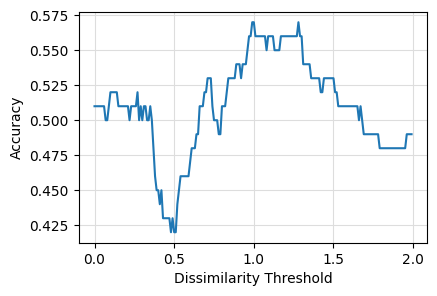

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

plt.rcParams['grid.color'] = '#DDDDDD'
plt.rcParams['grid.linewidth'] = 0.8

results_fn = MODEL_PATH + 'test_results_cnn.npy'
results = list(np.load(results_fn))

max = 0
for _, r in results:
  if r > max:
    max = r

thr = []
acc = []
for t in range(ceil(max*10)*10):
  t /= 100
  correct = 0
  for label, dist in results:
    if dist > t:
      pred = 0
    else:
      pred = 1
    if pred == int(label):
      correct += 1
  thr.append(t)
  acc.append(correct/len(results))

plt.figure(figsize=(4.5,3))
plt.plot(thr,acc)
plt.grid(True)
plt.xlabel('Dissimilarity Threshold')
plt.ylabel('Accuracy')
print('Test Set')
plt.show()

Validation Set


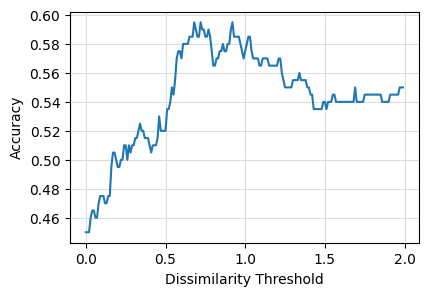

In [ ]:
results_fn = MODEL_PATH + 'validation_results_cnn.npy'
results = list(np.load(results_fn))

max = 0
for _, r in results:
  if r > max:
    max = r

thr = []
acc = []
for t in range(round(max*10)*10):
  t /= 100
  correct = 0
  for label, dist in results:
    if dist > t:
      pred = 0
    else:
      pred = 1
    if pred == int(label):
      correct += 1
  thr.append(t)
  acc.append(correct/len(results))

plt.figure(figsize=(4.5,3))
plt.plot(thr,acc)
plt.grid(True)
plt.xlabel('Dissimilarity Threshold')
plt.ylabel('Accuracy')
print('Validation Set')
plt.show()

In [ ]:
plt.figure(figsize=(4.5,3))
plt.plot(counter, loss_history)
plt.grid(True)
plt.ylabel('Contrastive Loss Value')
plt.xlabel('Iteration Number')
plt.show()

Arrange folders:



In [ ]:
#  #### useless


# ratio=0.8
# source_dir = FAKE_DIR + 'cropped'
# training_dir = FAKE_DIR + 'training'
# validation_dir = FAKE_DIR + 'validation'
# testing_dir = FAKE_DIR + 'testing'

# if os.path.isdir(training_dir):
#   shutil.rmtree(training_dir, ignore_errors=True)
#   shutil.rmtree(validation_dir, ignore_errors=True)
#   shutil.rmtree(testing_dir, ignore_errors=True)

# os.mkdir(training_dir)
# os.mkdir(validation_dir)
# os.mkdir(testing_dir)

# files = os.listdir(source_dir)

# # splitting
# for file in files:
#     if int(getid(file)) in [22,50,60,16,41,11,32,28,19,55,7,2]:
#         shutil.copy2(os.path.join(source_dir, file), os.path.join(testing_dir, file))

# training_files = rd.sample(files, int(ratio * len(files)))
# for file in training_files:
#   if int(getid(file)) not in [22,50,60,16,41,11,32,28,19,55,7,2]:
#     shutil.copy2(os.path.join(source_dir, file), os.path.join(training_dir, file))

# testing_files = set(files) - set(training_files)
# for file in testing_files:
#   if int(getid(file)) not in [22,50,60,16,41,11,32,28,19,55,7,2]:
#     shutil.copy2(os.path.join(source_dir, file), os.path.join(validation_dir, file))

# # # labeling
# # for directory in [training_dir, testing_dir, validation_dir]:
# #   files = os.listdir(directory)
# #   for file in files:
# #     label = file.split("-")[0]
# #     if not os.path.isdir(os.path.join(directory, label)):
# #         os.mkdir(os.path.join(directory, label))
# #     os.rename(os.path.join(directory, file), os.path.join(directory, label, file))

In [ ]:
# from pathlib import Path

# # labeling real in testing directory
# dir = FAKE_DIR + 'testing/real'
# # files = os.listdir(dir)
# dir_path = Path(dir)
# mp4_files = dir_path.glob("*.mp4")
# for file in mp4_files:
#   print
#   label = file.split("_")[0]
#   if not os.path.isdir(os.path.join(dir, label)):
#       os.mkdir(os.path.join(dir, label))
#   os.rename(os.path.join(dir, file), os.path.join(dir, label, file))
